# Introduction / Setup

This notebook shows how to use LangChain's [`LLMGraphTransformer`](https://python.langchain.com/docs/use_cases/graph/constructing/#llm-graph-transformer) to extract knowledge triples and store them in [DataStax AstraDB](https://www.datastax.com/products/datastax-astra).

In [ ]:
!python3 --version

Python 3.10.12


In [ ]:
# (Optional) When developing locally, this reloads the module code when changes are made,
# making it easier to iterate.
%load_ext autoreload
%autoreload 2

In [ ]:
# (Required in Colab) Install the knowledge graph library from the repository.
# This will also install the dependencies.
%pip install https://github.com/datastax-labs/knowledge-graphs-langchain/archive/main.zip

     \ 109.6 kB 827.3 kB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 71.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Environment
Pick one of the following.
1. If you're just running the notebook, it's probably best to run the cell using `getpass` to set the necessary
   environment variables.
1. If you're developing, it's likely easiest to create a `.env` file and store the necessary credentials.

In [ ]:
# (Option 1) - Set the environment variables from getpass.
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter OpenAI API Key: ")
os.environ["ASTRA_DB_DATABASE_ID"] = input("Enter Astra DB Database ID: ")
os.environ["ASTRA_DB_APPLICATION_TOKEN"] = getpass.getpass("Enter Astra DB Application Token: ")

keyspace = input("Enter Astra DB Keyspace (Empty for default): ")
if keyspace:
    os.environ["ASTRA_DB_KEYSPACE"] = keyspace
else:
    os.environ.pop("ASTRA_DB_KEYSPACE", None)

Enter OpenAI API Key: ··········
Enter Astra DB Database ID: 956bf68d-4b5d-46be-ae16-2bc3d49f1fce
Enter Astra DB Application Token: ··········
Enter Astra DB Keyspace (Empty for default): 


In [ ]:
# (Option 2) - Load the `.env` file.
# See `env.template` for an example of what you should have there.
%pip install python-dotenv
import dotenv
dotenv.load_dotenv()

False

## Initialize Astra DB / Cassandra

In [ ]:
# Initialize cassandra connection from environment variables).
import cassio
cassio.init(auto=True)

ERROR:cassandra.connection:Closing connection <LibevConnection(140601811921616) 956bf68d-4b5d-46be-ae16-2bc3d49f1fce-us-east-2.db.astra.datastax.com:29042:da337f5a-b9d1-4c81-b30e-fdbfcbe049ac> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


## Create Graph Store

In [ ]:
# Create graph store.
from knowledge_graph.cassandra_graph_store import CassandraGraphStore
graph_store = CassandraGraphStore()

# Extracting Knowledge Graph

In [ ]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI

# Prompt used by LLMGraphTransformer is tuned for Gpt4.
llm = ChatOpenAI(temperature=0, model_name="gpt-4")

llm_transformer = LLMGraphTransformer(llm=llm)

In [83]:
from langchain_core.documents import Document

text = """
Sam Altman is a prominent entrepreneur, investor, and executive known for his influential role in the tech industry. He is the CEO of OpenAI, an organization dedicated to advancing artificial intelligence in a safe and beneficial manner. Before joining OpenAI, Altman was the president of Y Combinator, a leading startup accelerator that has helped launch numerous successful companies. His career includes co-founding Loopt, a location-based social networking app, which was acquired by Green Dot Corporation. Altman is also known for his investments in various high-profile startups and his active involvement in discussions around technology, innovation, and societal impact.
"""
documents = [Document(page_content=text)]
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='Sam Altman', type='Person'), Node(id='Openai', type='Organization'), Node(id='Y Combinator', type='Organization'), Node(id='Loopt', type='Product'), Node(id='Green Dot Corporation', type='Organization'), Node(id='Artificial Intelligence', type='Concept'), Node(id='Technology', type='Concept'), Node(id='Innovation', type='Concept'), Node(id='Societal Impact', type='Concept')]
Relationships:[Relationship(source=Node(id='Sam Altman', type='Person'), target=Node(id='Openai', type='Organization'), type='CEO'), Relationship(source=Node(id='Sam Altman', type='Person'), target=Node(id='Y Combinator', type='Organization'), type='PRESIDENT'), Relationship(source=Node(id='Sam Altman', type='Person'), target=Node(id='Loopt', type='Product'), type='CO-FOUNDER'), Relationship(source=Node(id='Loopt', type='Product'), target=Node(id='Green Dot Corporation', type='Organization'), type='ACQUIRED_BY'), Relationship(source=Node(id='Openai', type='Organization'), target=Node(id='Artificial 

In [84]:
# Save the extracted graph documents to the AstraDB / Cassandra Graph Store.
graph_store.add_graph_documents(graph_documents)

### Optional: Predefine entities / relationships

The below shows how to configure the `LLMGraphTransformer` with specific kinds of nodes and relationships it is allowed to extract.
This is useful for constraining what will be extracted.

```python
llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Person", "Country", "Organization"],
    allowed_relationships=["NATIONALITY", "LOCATED_IN", "WORKED_AT", "SPOUSE"],
)
graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(
    documents
)
print(f"Nodes:{graph_documents_filtered[0].nodes}")
print(f"Relationships:{graph_documents_filtered[0].relationships}")
```

# Querying

We can query the `GraphStore` directly. The `as_runnable` method takes some configuration for how to extract the subgraph and returns a LangChain `Runnable` which can be invoked on a node or sequence of nodes to traverse from those starting points.

In [86]:
from knowledge_graph.traverse import Node

graph_store.as_runnable(steps=2).invoke(Node("Sam Altman", "Person"))

{Loopt (Product) -> Green Dot Corporation (Organization): ACQUIRED_BY,
 Openai (Organization) -> Artificial Intelligence (Concept): ADVANCES,
 Sam Altman (Person) -> Innovation (Concept): INVOLVED_IN_DISCUSSIONS,
 Sam Altman (Person) -> Loopt (Product): CO-FOUNDER,
 Sam Altman (Person) -> Openai (Organization): CEO,
 Sam Altman (Person) -> Societal Impact (Concept): INVOLVED_IN_DISCUSSIONS,
 Sam Altman (Person) -> Technology (Concept): INVOLVED_IN_DISCUSSIONS,
 Sam Altman (Person) -> Y Combinator (Organization): PRESIDENT}

For getting started, the library also provides a `Runnable` for extracting the starting entities from a question.

In [88]:
# Example showing extracted entities (nodes)
from knowledge_graph import extract_entities
extract_entities(llm).invoke({ "question": "Who is Sam Altman?"})

[Sam Altman (Person)]

## Query Chain

We'll create a chain which does the following:

1. Use the entity extraction `Runnable` from the library in order to determine the starting points.
2. Retrieve the sub-knowledge graphs starting from those nodes.
3. Create a context containing those knowledge triples.
4. Apply the LLM to answer the question given the context.

In [89]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from knowledge_graph import extract_entities
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name = "gpt-4")

def _combine_relations(relations):
    return "\n".join(map(repr, relations))

ANSWER_PROMPT = (
    "The original question is given below."
    "This question has been used to retrieve information from a knowledge graph."
    "The matching triples are shown below."
    "Use the information in the triples to answer the original question.\n\n"
    "Original Question: {question}\n\n"
    "Knowledge Graph Triples:\n{context}\n\n"
    "Response:"
)

chain = (
    { "question": RunnablePassthrough() }
    | RunnablePassthrough.assign(entities = extract_entities(llm))
    | RunnablePassthrough.assign(triples = itemgetter("entities") | graph_store.as_runnable())
    | RunnablePassthrough.assign(context = itemgetter("triples") | RunnableLambda(_combine_relations))
    | ChatPromptTemplate.from_messages([ANSWER_PROMPT])
    | llm
)

## Example
And finally, we can run the chain end to end to answer a question using the retrieved knowledge.

In [90]:
chain.invoke("Who is Sam Altman?")

AIMessage(content='Sam Altman is a person who is involved in discussions about technology, innovation, and societal impact. He is the CEO of Openai, an organization that advances artificial intelligence. He is also the president of Y Combinator and co-founder of a product called Loopt.', response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 201, 'total_tokens': 257}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-922658ee-83e3-4e71-b262-fee78664aa9c-0')

In [91]:
# Print the nodes and relationships to verify correctness
for doc in graph_documents:
    print("Nodes:")
    for node in doc.nodes:
        print(f"ID: {node.id}, Type: {node.type}")
    print("\nRelationships:")
    for relationship in doc.relationships:
        print(f"Source: {relationship.source}, Target: {relationship.target}, Type: {relationship.type}")


Nodes:
ID: Sam Altman, Type: Person
ID: Openai, Type: Organization
ID: Y Combinator, Type: Organization
ID: Loopt, Type: Product
ID: Green Dot Corporation, Type: Organization
ID: Artificial Intelligence, Type: Concept
ID: Technology, Type: Concept
ID: Innovation, Type: Concept
ID: Societal Impact, Type: Concept

Relationships:
Source: id='Sam Altman' type='Person', Target: id='Openai' type='Organization', Type: CEO
Source: id='Sam Altman' type='Person', Target: id='Y Combinator' type='Organization', Type: PRESIDENT
Source: id='Sam Altman' type='Person', Target: id='Loopt' type='Product', Type: CO-FOUNDER
Source: id='Loopt' type='Product', Target: id='Green Dot Corporation' type='Organization', Type: ACQUIRED_BY
Source: id='Openai' type='Organization', Target: id='Artificial Intelligence' type='Concept', Type: ADVANCES
Source: id='Sam Altman' type='Person', Target: id='Technology' type='Concept', Type: INVOLVED_IN_DISCUSSIONS
Source: id='Sam Altman' type='Person', Target: id='Innovation

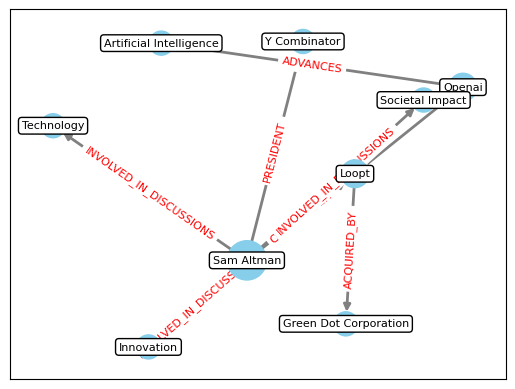

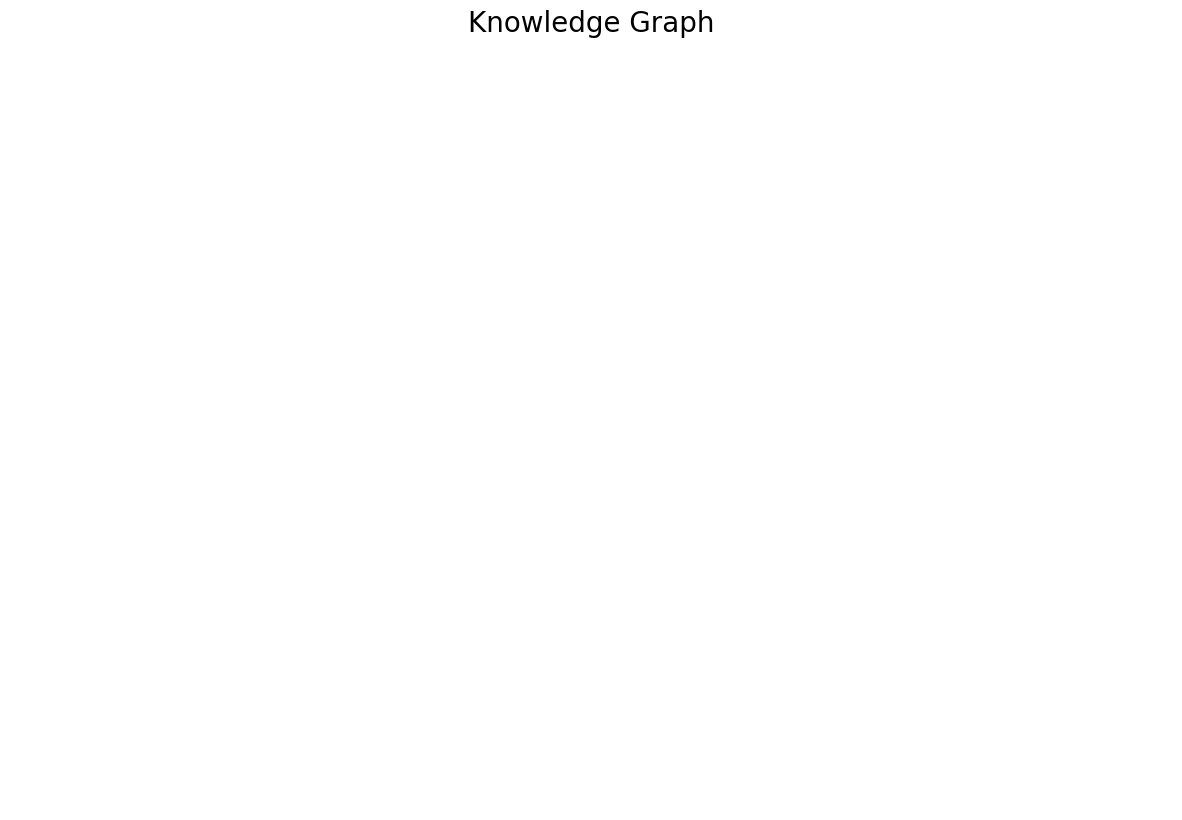

In [99]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(graph_documents):
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    for doc in graph_documents:
        for node in doc.nodes:
            if node.id:  # Use only the id for labels
                G.add_node(str(node.id), label=node.id)

        for relationship in doc.relationships:
            if relationship.source and relationship.target:  # Ensure relationships are valid
                G.add_edge(str(relationship.source.id), str(relationship.target.id), label=relationship.type)

    # Identify all nodes that are sources of relationships
    source_nodes = set(relationship.source.id for doc in graph_documents for relationship in doc.relationships)

    # Get positions for the nodes
    pos = nx.spring_layout(G, k=2, iterations=100, center=(0.5, 0.5))  # Increase k value for more spacing

    # Override positions for source nodes to be at the center
    center_positions = [(0.5 + 0.5 * i, 0.5*i) for i in range(len(source_nodes))]  # Distribute center nodes slightly
    for i, node in enumerate(source_nodes):
        if node in pos:
            pos[node] = center_positions[i % len(center_positions)]

    # Nodes with sizes based on their degree, reduced size
    node_sizes = [200 + 100 * G.degree(node) for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')

    # Ensure every node has a label, defaulting to the node ID
    node_labels = {node: G.nodes[node].get('label', node) for node in G.nodes}

    # Node labels with increased font size and padding
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_family='sans-serif',
                            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    # Edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, edge_color='gray')

    # Edge labels with increased font size
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5, font_color='red')

    plt.figure(figsize=(15, 10))  # Increase figure size
    plt.title("Knowledge Graph", fontsize=20)
    plt.axis('off')  # Hide axis
    plt.show()

# Visualize the extracted graph
visualize_graph(graph_documents)
